In [1]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(seed=10)

### Read json data

In [69]:
# shuffle train set for cross-validation
train = pd.read_json('cooking_train.json').sample(frac=1)
test  = pd.read_json('cooking_test.json')

X_train = train['ingredients']
y_train = train['cuisine']
X_test  = test['ingredients']

print ('train recipes: ', train.shape[0])
print ('test  recipes: ', test.shape[0])
print
print ('train cuisines', sorted(set(train.cuisine)))


('train recipes: ', 30000)
('test  recipes: ', 9774)

('train cuisines', [u'brazilian', u'british', u'cajun_creole', u'chinese', u'filipino', u'french', u'greek', u'indian', u'irish', u'italian', u'jamaican', u'japanese', u'korean', u'mexican', u'moroccan', u'russian', u'southern_us', u'spanish', u'thai', u'vietnamese'])


### Show file data layout

In [82]:
print train.head(10)

           cuisine     id                                        ingredients
18386      italian  18181  [light alfredo sauce, broccoli, vegetable oil,...
19184       korean   1890  [chicken wings, honey, sesame oil, pepper, asi...
18934      mexican   6016  [fresh cilantro, scallions, buttermilk, sour c...
10939      british  32330  [vanilla, powdered sugar, sour cream, heavy cr...
15036       french  48378  [cold water, salt, large eggs, cold milk, all-...
11695        greek  19322  [dried currants, olive oil, hot water, pinenut...
14290     filipino  10577  [sugar, dry bread crumbs, bread, evaporated mi...
19195      spanish  36677  [green olives, parsley, sun-dried tomatoes, fr...
22026  southern_us  13806  [flour, salt, butter, baking powder, shortenin...
8435       italian   8297  [purple onion, fresh rosemary, sliced mushroom...


### Show example ingredients

In [66]:
print train.ingredients[:10]

20412    [manchego cheese, serrano ham, extra-virgin ol...
1296     [sesame seeds, green onions, granulated sugar,...
3906     [golden raisins, salt, sugar, butter, baking p...
20454    [cauliflower, fresh ginger, coarse salt, salt,...
5200     [salmon, umeboshi, salt, nori, bonito flakes, ...
13595    [chiles, green pepper, tomatoes, boneless skin...
23974    [pepper, all-purpose flour, top round steak, f...
6980     [coriander seeds, sea salt, fresh mint, frozen...
2613     [shredded cheddar cheese, ranch dressing, mash...
23871    [olive oil, raw sugar, seedless red grapes, fr...
Name: ingredients, dtype: object


In [110]:
train.groupby(['cuisine']).size()

cuisine
brazilian        352
british          600
cajun_creole    1160
chinese         2014
filipino         564
french          1983
greek            898
indian          2285
irish            498
italian         5894
jamaican         404
japanese        1076
korean           616
mexican         4886
moroccan         605
russian          360
southern_us     3280
spanish          741
thai            1164
vietnamese       620
dtype: int64

### Vectorize X data

In [3]:
# remove non-alphabet letters
def preprocess_ingredient(i):
    regex = re.compile('[^a-z]')
    return regex.sub(' ', i.lower())

# vectorize ingredients from recipe
def preprocessor(r):
    r = [preprocess_ingredient(i) for i in r]
    return ' '.join(r).lower()

vect = TfidfVectorizer(preprocessor=preprocessor)

X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

### Show tf-idf transformation

In [81]:
show_vect = TfidfVectorizer(preprocessor=preprocessor)
vector = show_vect.fit_transform(recipes).todense()

pd.DataFrame(data=vector, columns=sorted(show_vect.vocabulary_))

,active,alfredo,all,apricots,asian,baking,basmati,black,bread,broccoli,...,sugar,sun,thighs,tomatoes,vanilla,vegetable,verde,water,wings,yeast
0,0.000000,0.305927,0.000000,0.305927,0.00000,0.000000,0.000000,0.000000,0.000000,0.305927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.305927,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.22916,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.22916,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.312508,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.248826,0.000000,0.000000,0.000000,0.292705,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.000000,0.000000,0.309029,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.229834,0.00000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.234242,0.234242,0.000000,0.000000,...,0.000000,0.199127,0.000000,0.199127,0.000000,0.000000,0.000000,0.348425,0.00000,0.000000
6,0.218644,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.655933,0.000000,...,0.185868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.218644
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.218924,0.000000,0.218924,0.000000,0.000000,0.000000,0.191533,0.00000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.438719,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.360732,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Transform cuisines to labels

In [4]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

### Prediction

In [5]:
model1 = ExtraTreesClassifier(n_estimators=150, random_state=10)
model2 = SVC(C=10, gamma=1, verbose=True, cache_size=1000, probability=True, random_state=10)

model = VotingClassifier(estimators=[('svc', model2), ('extra', model1)], voting='soft', weights=[2,1])
model.fit(X_train, y_train)

y_test = model.predict(X_test)
prediction = le.inverse_transform(y_test)

[LibSVM]

/home/hubert/Documents/JNP_2/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/hubert/Documents/JNP_2/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Save results to file .csv

In [7]:
submission = test.copy()

submission['cuisine'] = prediction
submission.to_csv('submission.csv', index=False, columns=['id', 'cuisine'])

### Important features in extra trees submodel

In [93]:
tree_model = model.estimators_[1]

#invert map
inv_map = {v: k for k, v in vect.vocabulary_.iteritems()}

importances = tree_model.feature_importances_
sorted_feat = np.argsort(importances)[::-1]

print("Most important features in extra trees:")
for feature in range(50):
    print("%d. %s (%f)" % (feature + 1, str(inv_map[sorted_feat[feature]]), importances[sorted_feat[feature]]))

Most important features in extra trees:
1. soy (0.011242)
2. cilantro (0.010838)
3. cheese (0.010585)
4. parmesan (0.010193)
5. tortillas (0.010101)
6. olive (0.010048)
7. salt (0.009864)
8. oil (0.009507)
9. sauce (0.009319)
10. ginger (0.009255)
11. sugar (0.009205)
12. cumin (0.008793)
13. lime (0.008499)
14. pepper (0.008094)
15. garlic (0.007883)
16. butter (0.007788)
17. sesame (0.007156)
18. corn (0.007044)
19. water (0.006881)
20. milk (0.006806)
21. fish (0.006682)
22. ground (0.006606)
23. basil (0.006569)
24. onions (0.006516)
25. fresh (0.006353)
26. salsa (0.006311)
27. rice (0.006202)
28. eggs (0.006177)
29. flour (0.006069)
30. powder (0.006062)
31. curry (0.006038)
32. garam (0.005766)
33. tomatoes (0.005464)
34. lemon (0.005316)
35. green (0.005289)
36. chili (0.005285)
37. black (0.005188)
38. sour (0.005043)
39. masala (0.005034)
40. grated (0.005032)
41. juice (0.005003)
42. chicken (0.004997)
43. parsley (0.004968)
44. wine (0.004849)
45. white (0.004759)
46. avoca

### Indicative plot showing how much more important are some features than others

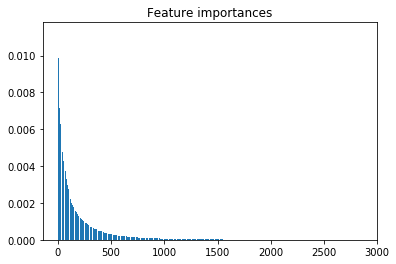

In [42]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[sorted_feat], align="center")
plt.show()

### Print number of supporting vectors in each class

In [64]:
vector_model = model.estimators_[0]

print "Number of supporting vectors: " + str(len(vector_model.support_))

Number of supporting vectors: 21714


In [139]:
for cuisine in range(0, 20):
    name = str(le.classes_[cuisine])
    supp_vect = vector_model.n_support_[cuisine]
    total_vect = train.groupby(['cuisine']).size()[name]
    print "%2d. %12s - %d/%d \t %.2f%%" % (cuisine + 1, name, supp_vect, total_vect, 100.0*supp_vect/total_vect)

 1.    brazilian - 319/352 	 90.62%
 2.      british - 590/600 	 98.33%
 3. cajun_creole - 905/1160 	 78.02%
 4.      chinese - 1475/2014 	 73.24%
 5.     filipino - 527/564 	 93.44%
 6.       french - 1876/1983 	 94.60%
 7.        greek - 685/898 	 76.28%
 8.       indian - 1449/2285 	 63.41%
 9.        irish - 476/498 	 95.58%
10.      italian - 3755/5894 	 63.71%
11.     jamaican - 344/404 	 85.15%
12.     japanese - 792/1076 	 73.61%
13.       korean - 479/616 	 77.76%
14.      mexican - 2358/4886 	 48.26%
15.     moroccan - 469/605 	 77.52%
16.      russian - 345/360 	 95.83%
17.  southern_us - 2716/3280 	 82.80%
18.      spanish - 697/741 	 94.06%
19.         thai - 877/1164 	 75.34%
20.   vietnamese - 580/620 	 93.55%
